In [3]:
# !python video_test2.py
!python img_test.py


image 1/1 c:\Users\jorge\Desktop\GymGuard\yolo\videos\input\my_squats_img.jpg: 640x384 1 person, 79.5ms
Speed: 2.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\pose\predict2


- No important # of reps
- Important: predict when will fail

- Now: only YOLO (front 2D view) + Design Proposal (Mech & Electr)
- Then: YOLO + MDE for analysis from side views (3D pose estimation) + Pattern using sensors
- 

1. VIZ (move)
2. PCA
2. VIZ x 2
4. Data
4. Pred

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt

sys.path.append(os.getcwd())

def format_cols(df):
    for col in df.columns:
        if df[col].dtype != 'O':
            continue
        df[col] = df[col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        df[[f'{col}_x', f'{col}_y']] = pd.DataFrame(df[col].tolist(), index=df.index)
        del df[col]
    return df


file_path = "videos/output/my_squats_vid.csv"
df = pd.read_csv(file_path)

# PREPROCESSING
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df = format_cols(df)
df.loc[:, (df.columns.str.contains('x')) | (df.columns.str.contains('y'))] = df.loc[:, (df.columns.str.contains('x')) | (df.columns.str.contains('y'))].replace(0.0, np.nan)
del df['timestamp']
del df['left_ear_x']
del df['left_ear_y']
df.head(3)


,frame,person,date,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0,2024-11-09 21:30:02.112986803,338.098541,394.321014,NaN,NaN,331.826202,385.282013,302.359161,...,157.525528,570.889832,260.874451,585.919739,285.845612,600.457275,194.329941,692.375610,196.933990,707.914307
1,0,0,2024-11-09 21:30:02.791515350,337.908722,404.471619,NaN,NaN,331.195221,396.152466,300.480927,...,157.863235,578.310242,258.980042,589.516052,285.818176,600.775024,191.573441,696.429382,194.649139,708.592590
2,0,0,2024-11-09 21:30:03.314315796,336.734924,408.669373,NaN,NaN,329.254822,400.493652,298.806519,...,159.389633,579.375366,259.643402,591.776733,287.707520,603.098328,190.384064,697.163147,196.698639,710.111816


In [4]:
person_id = 0
df_p = df[df.person == person_id].reset_index(drop=True)
# PREPROCESSING FOR PERSON MOVEMENTS
x_joints = df_p.loc[:,df_p.columns.str.contains('x')].describe()
min_x = x_joints.loc["min",:].min()
max_x = x_joints.loc["max",:].max()
y_joints = df_p.loc[:,df_p.columns.str.contains('y')].describe()
min_y = y_joints.loc["min",:].min()
max_y = y_joints.loc["max",:].max()
df_p.loc[:,df_p.columns.str.contains('x')] = df_p.loc[:,df_p.columns.str.contains('x')] / max_x
df_p.loc[:,df_p.columns.str.contains('y')] = df_p.loc[:,df_p.columns.str.contains('y')] / max_y
df_p.loc[:,df_p.columns.str.contains('y')] = 1 - df_p.loc[:,df_p.columns.str.contains('y')]
df_p.head(3)

,frame,person,date,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0,2024-11-09 21:30:02.112986803,0.883946,0.477709,NaN,NaN,0.998851,0.489682,0.790506,...,0.411844,0.243838,0.682046,0.223931,0.747332,0.204675,0.508068,0.082927,0.514876,0.062345
1,0,0,2024-11-09 21:30:02.791515350,0.883449,0.464265,NaN,NaN,0.998853,0.475284,0.785596,...,0.412727,0.234010,0.677093,0.219167,0.747261,0.204254,0.500861,0.077557,0.508903,0.061447
2,0,0,2024-11-09 21:30:03.314315796,0.880380,0.458704,NaN,NaN,0.998860,0.469533,0.781218,...,0.416718,0.232599,0.678828,0.216173,0.752200,0.201177,0.497752,0.076585,0.514261,0.059434


In [7]:
# MELT THE DATA TO LONG FORMAT FOR DATETIME VISUALIZATION
df_p_melted = df_p.melt(id_vars=[ 'frame', 'person', 'date'], 
                        value_vars=[col for col in df_p.columns if '_x' in col or '_y' in col], 
                        var_name='body_part', value_name='coordinate')

df_p_melted['axis'] = df_p_melted['body_part'].apply(lambda x: 'x' if '_x' in x else 'y')
df_p_melted['body_part'] = df_p_melted['body_part'].apply(lambda x: x.replace('_x', '').replace('_y', ''))

df_p_wide = df_p_melted.pivot_table(index=[ 'frame', 'person', 'date', 'body_part'], 
                                    columns='axis', values='coordinate').reset_index()

df_p_wide['body_part'] = df_p_wide['body_part'].replace({
    'left_elbow': 'elbow',
    'right_elbow': 'elbow',
    'left_knee': 'knee',
    'right_knee': 'knee',
    'left_shoulder': 'shoulder',
    'right_shoulder': 'shoulder',
    'left_hip': 'hip',
    'right_hip': 'hip',
    'left_wrist': 'wrist',
    'right_wrist': 'wrist',
    'left_ankle': 'ankle',
    'right_ankle': 'ankle',
    'left_eye': 'eye',
    'right_eye': 'eye',
    'left_ear': 'ear',
    'right_ear': 'ear',
    'nose': 'nose',
    'left_eye': 'eye',
    'right_eye': 'eye',

})
fig = px.scatter(df_p_wide, x="x", y="y",color="body_part", animation_frame="date", range_x=[0, 1], range_y=[0, 1], width=800, height=800)
fig.show()

In [28]:
X = df_p.loc[:,df_p.columns.str.contains('x') | df_p.columns.str.contains('y')]

X.corr().style.background_gradient(cmap='coolwarm')

c:\Users\jorge\anaconda3\envs\yolo\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning:

All-NaN slice encountered

c:\Users\jorge\anaconda3\envs\yolo\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning:

All-NaN slice encountered



,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
nose_x,1.000000,-0.736883,-0.999633,0.515300,-0.999368,-0.735684,nan,nan,0.995586,-0.727064,0.821531,-0.712976,0.980822,-0.721832,0.903311,-0.618736,0.890060,-0.724735,0.774271,-0.535747,0.813223,-0.344448,-0.625763,-0.675811,-0.555092,-0.674245,0.589519,-0.639568,0.675019,-0.693538,-0.333487,0.105841,0.362376,0.110353
nose_y,-0.736883,1.000000,-0.503380,0.999902,0.742669,0.999977,nan,nan,-0.762147,0.999549,-0.275746,0.998645,-0.767260,0.998939,-0.653316,0.992056,-0.905424,0.997178,-0.339328,0.878944,-0.774545,0.716522,0.949555,0.992739,0.904567,0.992913,-0.808788,0.895315,-0.931314,0.903550,0.343849,0.224837,-0.414636,0.196035
left_eye_x,-0.999633,-0.503380,1.000000,-0.513513,0.999583,-0.515114,nan,nan,-0.996037,-0.580680,-0.979595,-0.620906,-0.996739,-0.592285,-0.999434,-0.481301,-0.959533,-0.598163,-0.891076,-0.046320,-0.906044,-0.962512,-0.689776,-0.651415,-0.703538,-0.647257,-0.135377,-0.347088,0.580871,-0.012498,-0.364014,-0.484953,0.733020,-0.667220
left_eye_y,0.515300,0.999902,-0.513513,1.000000,-0.501864,0.999948,nan,nan,0.444571,0.996470,0.496744,0.989579,0.523806,0.991471,0.863863,0.839524,0.340174,0.971198,0.065236,-0.774678,0.286728,0.507977,0.899250,0.974786,0.933854,0.975002,-0.689757,0.801286,-0.961472,0.680670,-0.535341,0.914291,-0.322842,0.949033
right_eye_x,-0.999368,0.742669,0.999583,-0.501864,1.000000,0.741369,nan,nan,-0.997050,0.732447,-0.815640,0.718753,-0.978937,0.727260,-0.899579,0.624161,-0.890471,0.731381,-0.775973,0.546930,-0.817605,0.355563,0.631119,0.682135,0.560903,0.680548,-0.592639,0.650629,-0.678338,0.703207,0.329196,-0.085813,-0.372170,-0.091746
right_eye_y,-0.735684,0.999977,-0.515114,0.999948,0.741369,1.000000,nan,nan,-0.761033,0.999711,-0.274169,0.998800,-0.766623,0.999164,-0.653480,0.991311,-0.905844,0.996945,-0.338502,0.876342,-0.774850,0.714548,0.950570,0.992636,0.905664,0.992842,-0.808268,0.894924,-0.931779,0.903589,0.345959,0.222339,-0.414530,0.194522
left_ear_x,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
left_ear_y,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
right_ear_x,0.995586,-0.762147,-0.996037,0.444571,-0.997050,-0.761033,nan,nan,1.000000,-0.752964,0.802159,-0.740292,0.974280,-0.748271,0.899790,-0.635747,0.896447,-0.751418,0.777342,-0.549964,0.835686,-0.369832,-0.663012,-0.700711,-0.597847,-0.699544,0.618015,-0.671360,0.712021,-0.727282,-0.327292,0.087000,0.420463,0.069695
right_ear_y,-0.727064,0.999549,-0.580680,0.996470,0.732447,0.999711,nan,nan,-0.752964,1.000000,-0.262730,0.999369,-0.759420,0.999746,-0.647305,0.989136,-0.904217,0.996178,-0.330261,0.867912,-0.774478,0.709575,0.955373,0.992571,0.911735,0.992897,-0.809152,0.893369,-0.934514,0.902907,0.347889,0.218075,-0.414499,0.194460


In [29]:
X.loc[:,["left_ear_x","left_ear_y"]]

,left_ear_x,left_ear_y
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
222,NaN,NaN
223,NaN,NaN
224,NaN,NaN
225,NaN,NaN


In [19]:


# Extract x and y coordinates for each body part


plt.figure(figsize=(10,10))
left_s_x = df_p_f[['left_ankle_x','left_knee_x','left_hip_x','left_shoulder_x','left_elbow_x','left_wrist_x']].values.T
left_s_y = df_p_f[['left_ankle_y','left_knee_y','left_hip_y','left_shoulder_y','left_elbow_y','left_wrist_y']].values.T
plt.plot(left_s_x,left_s_y)
plt.xlim(0,1)
plt.ylim(0,1)


NameError: name 'df_p_f' is not defined

<Figure size 1000x1000 with 0 Axes>

In [18]:
left_ankle_x,left_knee_x,left_hip_x,left_shoulder_x,left_elbow_x,left_wrist_x = df_p[['left_ankle_x','left_knee_x','left_hip_x','left_shoulder_x','left_elbow_x','left_wrist_x']].values.T
left_ankle_x

array([206.25448608])

In [67]:
df_p[['left_ankle_x','left_knee_x','left_hip_x','left_shoulder_x','left_elbow_x','left_wrist_x']].values.T

array([[194.3299408 , 191.57344055, 190.38406372, ..., 220.80863953,
        207.27729797, 213.63790894],
       [260.87445068, 258.9800415 , 259.6434021 , ..., 244.70414734,
        233.85354614, 243.76049805],
       [127.81289673, 126.80873108, 130.73921204, ..., 169.99110413,
        170.27680969, 174.69371033],
       [241.98907471, 240.8256073 , 244.88102722, ..., 191.54774475,
        191.91786194, 192.75003052],
       [291.95330811, 290.74749756, 295.57781982, ..., 200.86236572,
        197.6566925 , 192.24578857],
       [335.84939575, 331.14086914, 334.92727661, ..., 243.52246094,
        243.26626587, 236.87379456]])

In [ ]:

plt.figure(figsize=(10, 8))



plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Human Body Parts Coordinates')
plt.legend()
plt.show()

In [6]:
pd.DataFrame(df.right_eye.to_list(), columns = ['x', 'y'])

ValueError: Shape of passed values is (1, 1), indices imply (1, 2)

In [7]:
df.right_eye.to_list()

['[331.2829895019531, 382.9031982421875]']

In [17]:
df.to_dict(orient='list')

{'frame': [0],
 'person': [0],
 'nose': ['[338.6487121582031, 390.9703674316406]'],
 'left_eye': ['[0.0, 0.0]'],
 'right_eye': ['[331.2829895019531, 382.9031982421875]'],
 'left_ear': ['[0.0, 0.0]'],
 'right_ear': ['[303.831298828125, 392.2688903808594]'],
 'left_shoulder': ['[243.27825927734375, 426.96722412109375]'],
 'right_shoulder': ['[287.8380432128906, 447.25079345703125]'],
 'left_elbow': ['[269.6033935546875, 510.5048828125]'],
 'right_elbow': ['[357.066162109375, 530.4229736328125]'],
 'left_wrist': ['[303.3880310058594, 486.54180908203125]'],
 'right_wrist': ['[378.2861633300781, 477.8900451660156]'],
 'left_hip': ['[125.1214599609375, 551.7201538085938]'],
 'right_hip': ['[151.49925231933594, 561.5819702148438]'],
 'left_knee': ['[272.9305725097656, 586.6785278320312]'],
 'right_knee': ['[293.2123718261719, 606.5951538085938]'],
 'left_ankle': ['[206.2545166015625, 677.9189453125]'],
 'right_ankle': ['[208.05728149414062, 708.631591796875]']}

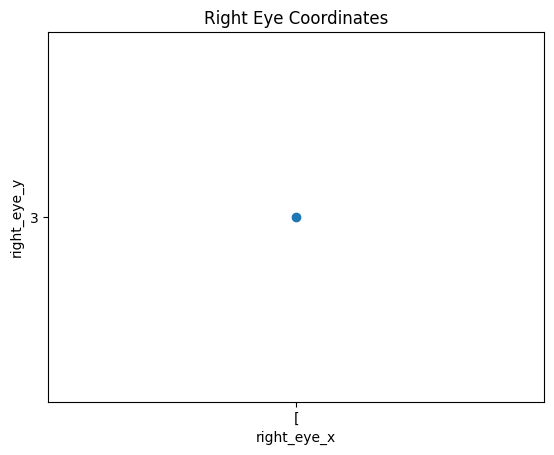

In [10]:
df.right_eye
import matplotlib.pyplot as plt

# Extract x and y coordinates for right_eye
right_eye_x = df['right_eye'].apply(lambda x: x[0])
right_eye_y = df['right_eye'].apply(lambda x: x[1])

# Plot the coordinates
plt.scatter(right_eye_x, right_eye_y)
plt.xlabel('right_eye_x')
plt.ylabel('right_eye_y')
plt.title('Right Eye Coordinates')
plt.show()

In [15]:
# Ensure all lists in the DataFrame columns are of the same length
df['nose'] = df['nose'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_eye'] = df['left_eye'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_eye'] = df['right_eye'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_ear'] = df['left_ear'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_ear'] = df['right_ear'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_shoulder'] = df['left_shoulder'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_shoulder'] = df['right_shoulder'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_elbow'] = df['left_elbow'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_elbow'] = df['right_elbow'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_wrist'] = df['left_wrist'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_wrist'] = df['right_wrist'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_hip'] = df['left_hip'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_hip'] = df['right_hip'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_knee'] = df['left_knee'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_knee'] = df['right_knee'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['left_ankle'] = df['left_ankle'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])
df['right_ankle'] = df['right_ankle'].apply(lambda x: x if isinstance(x, list) and len(x) == 2 else [None, None])

df[['nose_x', 'nose_y']] = pd.DataFrame(df['nose'].tolist(), index=df.index)
df[['left_eye_x', 'left_eye_y']] = pd.DataFrame(df['left_eye'].tolist(), index=df.index)
df[['right_eye_x', 'right_eye_y']] = pd.DataFrame(df['right_eye'].tolist(), index=df.index)
df[['left_ear_x', 'left_ear_y']] = pd.DataFrame(df['left_ear'].tolist(), index=df.index)
df[['right_ear_x', 'right_ear_y']] = pd.DataFrame(df['right_ear'].tolist(), index=df.index)
df[['left_shoulder_x', 'left_shoulder_y']] = pd.DataFrame(df['left_shoulder'].tolist(), index=df.index)
df[['right_shoulder_x', 'right_shoulder_y']] = pd.DataFrame(df['right_shoulder'].tolist(), index=df.index)
df[['left_elbow_x', 'left_elbow_y']] = pd.DataFrame(df['left_elbow'].tolist(), index=df.index)
df[['right_elbow_x', 'right_elbow_y']] = pd.DataFrame(df['right_elbow'].tolist(), index=df.index)
df[['left_wrist_x', 'left_wrist_y']] = pd.DataFrame(df['left_wrist'].tolist(), index=df.index)
df[['right_wrist_x', 'right_wrist_y']] = pd.DataFrame(df['right_wrist'].tolist(), index=df.index)
df[['left_hip_x', 'left_hip_y']] = pd.DataFrame(df['left_hip'].tolist(), index=df.index)
df[['right_hip_x', 'right_hip_y']] = pd.DataFrame(df['right_hip'].tolist(), index=df.index)
df[['left_knee_x', 'left_knee_y']] = pd.DataFrame(df['left_knee'].tolist(), index=df.index)
df[['right_knee_x', 'right_knee_y']] = pd.DataFrame(df['right_knee'].tolist(), index=df.index)
df[['left_ankle_x', 'left_ankle_y']] = pd.DataFrame(df['left_ankle'].tolist(), index=df.index)
df[['right_ankle_x', 'right_ankle_y']] = pd.DataFrame(df['right_ankle'].tolist(), index=df.index)
df

,timestamp,frame,person,nose,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
1,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
2,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
3,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
4,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
223,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
224,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
225,1.731188e+09,0,0,"[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]","[None, None]",...,None,None,None,None,None,None,None,None,None,None
